## Model Selection and explanations

As we have seen, before train some models, we have done some pre-modeling : interpretability methods that we use before selecting and developing our models. This has allow us to reduce the dimensionality of the problem.

With this new dataset, we have train models chosen on two purpose :
- Random Forest for is explainability : it's an in-model : by nature interpretable
- ANN for is modeling capacity. But this is a black box model thus it's a post-model (post-Hoc) : need interpretability techniques that try to enhance model interpretability after the model has been developed

We have chosen for both of our target the model of RF given better result in our sens, so we will focus on it.

We will proceed as follows :
- 1. Practice global interpretability : we want to have an overall description of different models
- 2. Self interpret the predictions made by our model. We mean have a look to the result, try to find some pattern (Unsupervised ML) and have an idea about how data are distributed in the predictions
- 3. Do some local interpretability : on the results of the second step, if we have find some "clusters" while describing the results, we will apply local methods on it

We are going to use library like Lime, Shap, Eli5 or Yellowbrick.

[lien] https://towardsdatascience.com/understanding-machine-learning-interpretability-168fd7562a1a https://towardsdatascience.com/three-interpretability-methods-to-consider-when-developing-your-machine-learning-model-5bf368b47fac https://www.analyticsvidhya.com/blog/2020/03/6-python-libraries-interpret-machine-learning-models/

In [115]:
#Classical Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

# Tools'libraries

from joblib import dump, load
#import shap
from lime import lime_tabular as LT
import eli5

In [101]:
# first we recup our data, models and target
%store -r X_train
%store -r X_test
%store -r t_inc
%store -r t_acc
columns = ["Age", "FinancialEducation/RiskPropensity", "logIncome", "logWealth", "Acc", "Inc"]
%store -r predRFAcc
%store -r predRFInc
#Load the model
rfModInc = load('../src/RandomForestInc.joblib')
rfModAcc = load('../src/RandomForestAcc.joblib')

%store -r data_mean
%store -r data_std

## ELI5
This library allow us to have a quick global interpretability on the model, it look at a model’s parameters and figure out at a global level how the model works.

Let's see on our two model for income and accumulation what are the results

In [102]:
#eli5.show_weights(rfModAcc, feature_names=columns[0:4]) # Return an explanation of estimator parameters (weights), for visualisation
testdf = eli5.explain_weights_df(rfModAcc,feature_names=columns[0:4]) # Explain weights and export them to pandas.DataFrame
testdf.head()


,feature,weight,std
0,logWealth,0.425098,0.039171
1,logIncome,0.342391,0.039259
2,Age,0.136883,0.022813
3,FinancialEducation/RiskPropensity,0.095627,0.019336


We can see that for accumulation investment, the most most impactful features are Wealth and Income. They account for approximately 75% of the prediction result. 

**financial interpretation ?**

The remaining 25% is reparted on Age and the ratio. The last one seems to have the lower impact.

In [103]:
eli5.show_weights(rfModInc, feature_names=columns[0:4])
testdfinc = eli5.explain_weights_df(rfModInc,feature_names=columns[0:4])
testdfinc.head()

,feature,weight,std
0,logWealth,0.475007,0.079430
1,Age,0.235697,0.069174
2,logIncome,0.182680,0.028308
3,FinancialEducation/RiskPropensity,0.106615,0.019574


We can see that for income investment, the most important features are Wealth and age. Wealth account for nearly 50% of the explanation, meaning the weigth of it is really strong on our prediction. 
**Financial interpretation ?**

Age have also a big impact here, more than for the accumulation model.

Let's plot to have a visualisation.


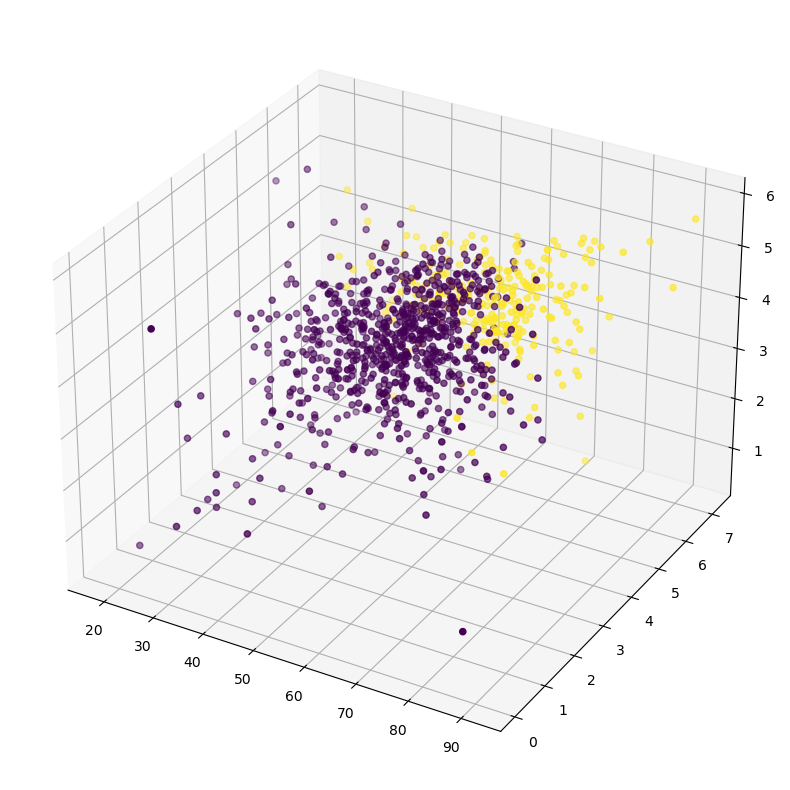

In [104]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_true["Age"], df_true["logWealth"],df_true["logIncome"], c=df_true["Inc"] ) 

plt.show()

There is nearly a separation when wealth go above a certain treshold. 

Let's use shap library to have a bit more of precision on how are distributed these weigth, if they account in a positive or negative way.

In [105]:
#shap.initjs()#this line is required for enabling JS with shap lib
#explainer = shap.TreeExplainer(rfModAcc)
#shap_values = explainer.shap_values(X_train)
#shap.summary_plot(shap_values, features=X_train, feature_names=feature_names)

# Conclusion on global interpretability

Feature importance and weigth for accu income ; expected or not ; positive negative ; 

Let's now see if there is some cluster inside people who have need or not. We are going to separate these people, then on each set, we are going to do first a data exploration, to have an idea and then to  train an UL model to see if some cluster appear

## let's see the data

In [106]:
data =  np.insert(X_test ,4, predRFAcc, axis=1)
data =  np.insert(data ,5, predRFInc, axis=1)
df = pd.DataFrame(data, columns=columns)
df_UL =  pd.DataFrame(X_test, columns=["Age", "FinancialEducation/RiskPropensity", "logIncome", "logWealth"])
#df.describe()

In [107]:
mean = [data_mean[0], data_mean[3]/data_mean[4], data_mean[5], data_mean[6],0, 0]
std = [data_std[0], data_std[3]/data_std[4], data_std[5], data_std[6],1, 1]

df_true = pd.DataFrame(df*std+mean, columns=columns)
df_true.describe()

,Age,FinancialEducation/RiskPropensity,logIncome,logWealth,Acc,Inc
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,54.786000,1.973353,3.865530,4.132356,0.435000,0.254000
std,11.741638,27.347839,0.798926,0.907781,0.496005,0.435515
min,18.000000,-703.465770,0.430330,0.057911,0.000000,0.000000
25%,47.000000,1.141692,3.427784,3.572470,0.000000,0.000000
50%,55.000000,1.932128,3.958148,4.178830,0.000000,0.000000
75%,63.000000,2.570810,4.428945,4.757747,1.000000,1.000000
max,92.000000,384.447699,5.900783,7.183172,1.000000,1.000000


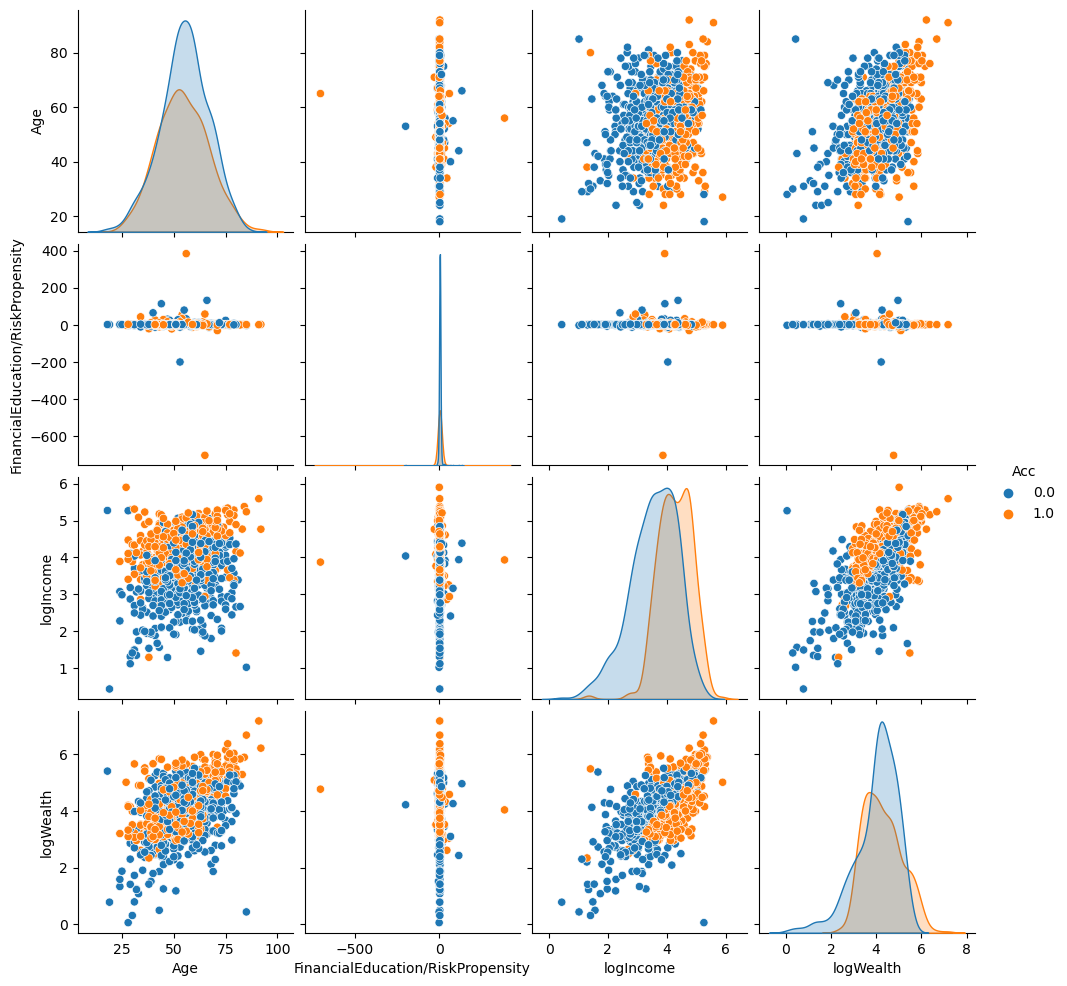

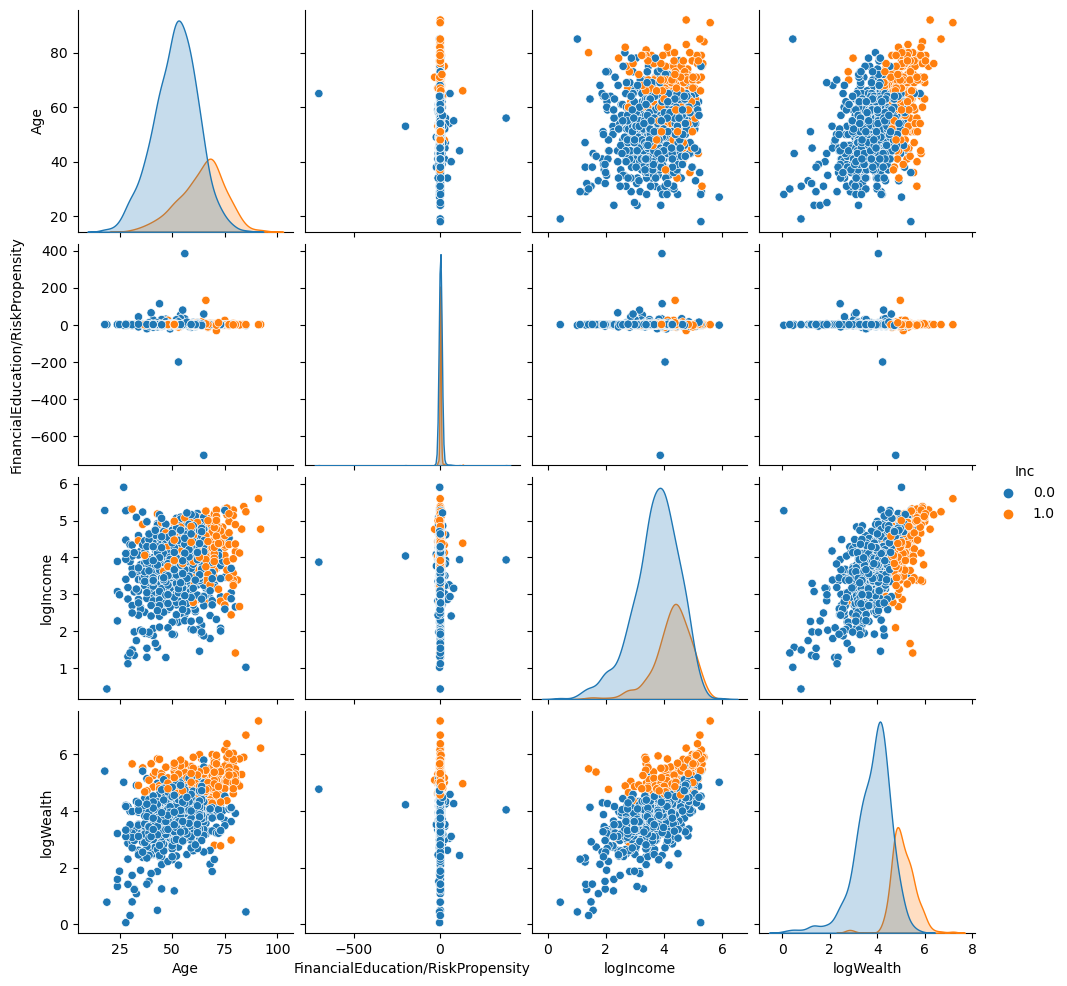

In [108]:
#Plot with the target IncomeInvestment
sns.pairplot(df_true[["Age", "FinancialEducation/RiskPropensity", "logIncome", "logWealth","Acc"]], hue="Acc", data=df)
#Plot with the target IncomeInvestment
sns.pairplot(df_true[["Age", "FinancialEducation/RiskPropensity", "logIncome", "logWealth","Inc"]], hue="Inc", data=df)

For accumulation, it is hard to see a pattern, only logincome seems to have a particular repartition.
However, as we have said, in income investment, the wealth play a big role and thus high wealth give prediction to true. We expect to have such a replication in clustering. Even age and logincome seems to have a particular shape. 

In [109]:
# let's recup exactly the peole who have need or not in both target
UL_test = df_UL.values
UL = df.values

Acc_true  = UL_test[(UL[:,4]==1)]
Acc_false = UL_test[(UL[:,4]==0)]

Inc_true  = UL_test[(UL[:,5]==1)]
Inc_false = UL_test[(UL[:,5]==0)]


Text(0, 0.5, 'Inertia (within-cluster sum of squares)')

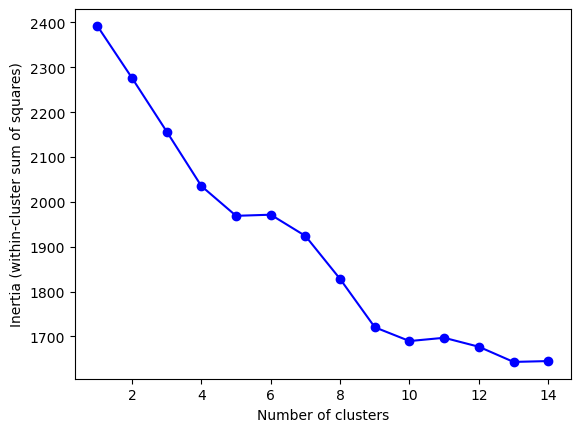

In [110]:
from sklearn_extra.cluster import KMedoids as KM


Km = range(1, 15)
inertia = [KM(i).fit(Acc_true).inertia_ for i in Km]

fig = plt.figure()
plt.plot(Km, inertia, '-bo')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (within-cluster sum of squares)')

In [111]:
medoids = KM(10).fit(UL_test)
labels = medoids.predict(Acc_true)
#plt.scatter(Acc_true[:, 0], Acc_true[:, 1], c=labels, s=40)

print(medoids.cluster_centers_*std[0:4] + mean[0:4])
a, count = np.unique(labels, return_counts=True)
print("classes",a,"distributed as :", count)

[[71.          2.88480128  4.65104662  5.29567803]
 [51.          0.31878009  4.13329511  4.08940645]
 [49.          2.38619807  3.94822049  3.97979394]
 [61.          1.87768428  4.59058713  4.56561126]
 [49.          1.84451166  4.38241172  4.84117527]
 [66.          1.67155543  3.9429569   4.69701509]
 [59.         -4.41255449  3.64487724  4.12280973]
 [47.          1.83829343  3.32491299  3.19880072]
 [57.         12.02348934  4.20659151  4.67297979]
 [65.          1.84176875  3.24180805  3.7583041 ]]
classes [0 1 2 3 4 5 6 7 8 9] distributed as : [60 70 91 55 36 24 24 44 19 12]


In [112]:
# if we want to see the repartition within a cluster
first = Acc_true[labels[:]==0]
tty = pd.DataFrame(first*std[0:4] + mean[0:4], columns=["Age", "FinancialEducation/RiskPropensity", "logIncome", "logWealth"])
tty.describe()

,Age,FinancialEducation/RiskPropensity,logIncome,logWealth
count,60.000000,60.000000,60.000000,60.000000
mean,68.933333,3.131831,4.745010,5.392748
std,8.550680,1.404973,0.494298,0.622705
min,52.000000,0.670778,3.382266,4.102450
25%,63.000000,2.132974,4.612903,4.864535
50%,69.000000,2.708741,4.805110,5.407265
75%,75.250000,3.743147,5.103396,5.844091
max,92.000000,6.449044,5.591129,7.183172


Text(0.5, 1.0, 'KMedoids clustering. Medoids are represented in cyan.')

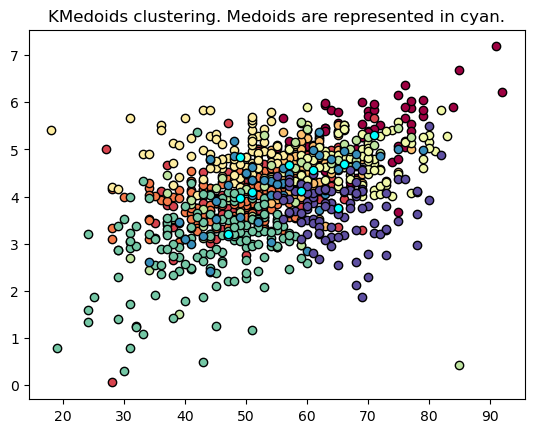

In [116]:
labels = medoids.labels_
cluster = medoids.cluster_centers_*std[0:4] + mean[0:4],
i, j = 0,3
unique_labels = set(labels)
colors = [
    plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))
]
for k, col in zip(unique_labels, colors):

    class_member_mask = labels == k

    xy = UL_test[class_member_mask]
    plt.plot(
        xy[:, i]*std[i] + mean[i],
        xy[:, j]*std[j] + mean[j],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.plot(
    medoids.cluster_centers_[:, i]*std[i] + mean[i],
    medoids.cluster_centers_[:, j]*std[j] + mean[j],
    "o",
    markerfacecolor="cyan",
    markeredgecolor="k",
    markersize=6,
)

plt.title("KMedoids clustering. Medoids are represented in cyan.")

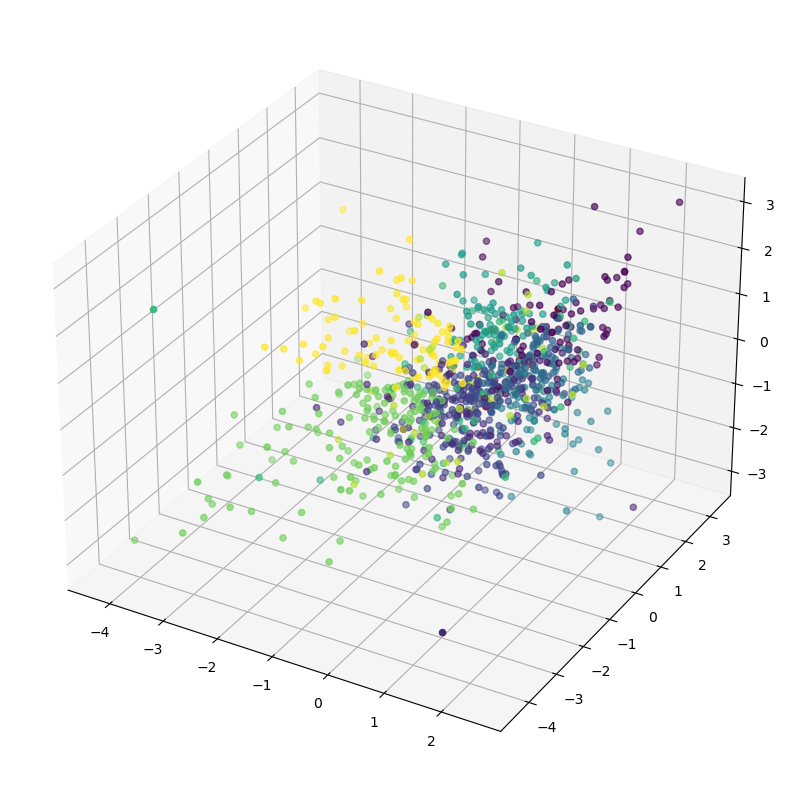

In [94]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(df["logIncome"], df["logWealth"],df["Age"], c=labels ) 
ax.scatter(medoids.cluster_centers_[:,2], medoids.cluster_centers_[:,3],medoids.cluster_centers_[:,0], c="r" ) 

plt.show()


# Local interpretability 

Do shap eli5 or other on : 
- cluster center
- exagerated data made by hand
- outlier or simple sample 

conclude